In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils import _page_width_, float_formatter
plt.rcParams['figure.figsize'] = 10,10

import plotly.express as px
from sklearn import datasets
import random
import sklearn

# K-Nearest Neighbor (KNN) Classifier

## KNN Recap
As the name suggests, this algorithm calculates the $k$ closest neighbors of a test datapoint and assigns it the majority class of those neighbors.
Since no model fitting is done, this is called a _non parametric_ algorithm. A consequence is that the prediction requires availability of whole training dataset.
The number $k$ is a hyperparameter.

## Distance Functions
There are different ways the distance to other datapoints can be calculated. Some of the most common ones are described below:

- Euclidean Distance : $d(a,b)=\sqrt{(a-b)^T(a-b)}$
- Manhattan Distance : $d(a,b)=\vert a-b \vert$
- Mahalanobis Distance : $d(a,b)=\sqrt{(a-b)^TS^{-1}(a-b)}$ where $S$ is the covariance matrix of the features
- Cosine Distance : $d(a,b)=\dfrac{a^Tb}{\vert a \vert \vert b \vert}$

## Dataset
We will use Iris Dataset for this demo.

In [2]:
from sklearn import datasets
iris = datasets.load_iris()
iris_df = pd.DataFrame(data=iris.data,columns=iris.feature_names)
iris_df['label'] = iris.target
target_names = {i:v for i,v in enumerate(iris.target_names)}
iris_df.label = iris_df.label.replace(target_names)

In [3]:
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [4]:
iris_df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


Splitting the dataset into train and test : 

In [5]:
TRAIN_RATIO = 0.9
msk = np.random.rand(len(iris_df)) < TRAIN_RATIO
train_df = iris_df[msk]
test_df = iris_df[~msk]

## Visualizations

In the following, you will be able to explore the dataset in both 2D and 3D. Since there are 4 features, you have to select which two (three) features you want to see

### 2D-Visualization

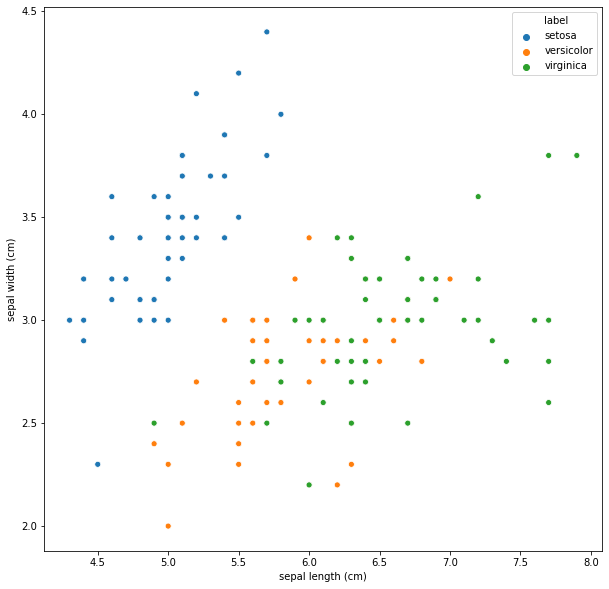

In [7]:
feature_x = iris.feature_names[0]
feature_y = iris.feature_names[1]
feature_z = iris.feature_names[2]
sns.scatterplot(x=iris_df[feature_x], y=iris_df[feature_y], hue=iris_df.label)

## Implementation

    The distance functions defined above are implemented as follows :

In [8]:
def distance_euclidean(a,b):
    return (a-b).T.dot(a-b)

def distance_manhattan(a,b):
    return np.sum(np.abs(a-b))

def distance_mahalanobis(a,b,S):
    return (a-b).T.dot(np.linalg.inv(S)).dot(a-b)

def distance_cosine(a,b):
    return a.dot(b)/(np.linalg.norm(a)*np.linalg.norm(b))

For the implementation of the algorithm itself, we calculate the distance of a given $test\_point$ with all points in the $train\_data$ using the $distance\_func$.
Then we find the $num\_neighbors (k)$ closest points using Numpy's argpartition() function. The function returns the labels of $k$ closest points and their distances.

The implementation of this function is as follows:

In [9]:
def knn_predict(test_point,train_data,distance_func,num_neighbors=3):

    train_data_numpy = train_data.to_numpy()[:,:-1] # dropping label column

    if distance_func=='distance_mahalanobis':
        S = train_data_numpy.T.dot(train_data_numpy)
        distances = np.array([func_dict[distance_func](test_point,x,S.astype('float')) for x in train_data_numpy])
    else:
        distances = np.array([func_dict[distance_func](test_point,x) for x in train_data_numpy])

    knn = np.argpartition(distances,range(num_neighbors+1))[1:num_neighbors+1]

    return train_data.label.iloc[knn]#, distances[knn]

Since there is no training involved, we simply find the distance of all test points with training dataset.
    The $test\_points$ generates tuples with the format : (index,dataframe_row). After getting the predictions for each point in test set, 
    we count the values of returend labels in the prediction and mark the label with highest frequency as $most\_common\_label$. Then we add all the results
    to a pandas dataframe.

In [10]:
test_points = test_df.iterrows()
knn_result = pd.DataFrame(columns=['true_label','pred_label'],index=range(len(test_df)))

In [14]:
distance_function = 'distance_euclidean'
num_neighbors = 3

func_dict = {'distance_euclidean':distance_euclidean,
                'distance_manhattan':distance_manhattan,
                'distance_mahalanobis':distance_mahalanobis,
                'distance_cosine':distance_cosine}

In [15]:
for i,x in enumerate(test_points):
    label_true = x[1].label
    test_point = x[1].values[:-1]

    labels_knn = knn_predict(test_point,train_df,distance_function,num_neighbors=num_neighbors)
    most_common_label = labels_knn.value_counts().index[0]
    knn_result.loc[i]=[label_true,most_common_label]

In [16]:
knn_result

,true_label,pred_label
0,versicolor,versicolor
1,versicolor,versicolor
2,versicolor,virginica
3,virginica,virginica
4,virginica,virginica
5,virginica,virginica
6,virginica,virginica
7,virginica,virginica
8,NaN,NaN
9,NaN,NaN
